In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Prepare data

## Load dataset

In [4]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])

train_labels = data["train_set"]['polarity']
val_labels = data["val_set"]['polarity']
test_labels = data["test_set"]['polarity']
class_names = data['class_names']

## Preprocess dataset

### Tokenize

In [5]:
from transformers import CamembertTokenizer

In [6]:
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [7]:
some_review = train_reviews[0]
some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [8]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [9]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [10]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Average length: 129.6
Max length: 512


/var/folders/4k/0zs7sw_s24n0wtqvj3s3c1900000gn/T/ipykernel_1435/2926094078.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))


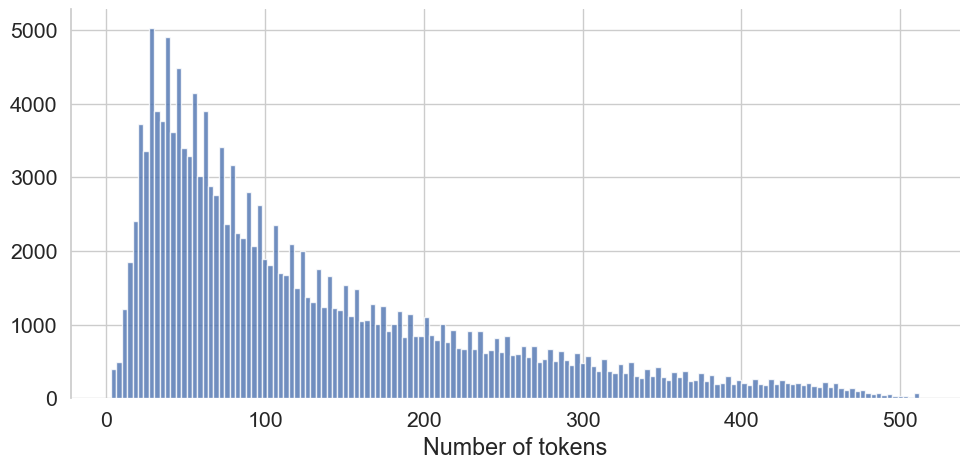

In [11]:
reviews_len = [len(tokenizer.encode(review, max_length=512))
                          for review in train_reviews]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/bert/number_of_tokens.png', dpi=200)

In [12]:
tokenizer.vocab_size

32005

In [13]:
MAX_SEQ_LEN = 400 # in terms of generated tokens (not words)

short_reviews = sum(np.array(reviews_len) <= MAX_SEQ_LEN)
long_reviews = sum(np.array(reviews_len) > MAX_SEQ_LEN)

print("{} reviews with LEN > {} ({:.2f} % of total data)".format(
    long_reviews,
    MAX_SEQ_LEN,
    100 * long_reviews / len(reviews_len)
))

4717 reviews with LEN > 400 (2.95 % of total data)


In [14]:
import numpy as np

def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [15]:
encoded_train = encode_reviews(tokenizer, train_reviews, MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, val_reviews, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, test_reviews, MAX_SEQ_LEN)

### Labels

In [16]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Preprocessing pipeline

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class CamembertPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def fit(self, X=None):
        pass
    
    def transform(self, X, y):
        # 1. Tokenize
        X_encoded = encode_reviews(self.tokenizer, X, self.max_seq_length)
        # 2. Labels
        y_array = np.array(y)
        return X_encoded, y_array     
    
    def fit_transform(self, X, y):        
        return self.transform(X, y)

# Model

In [18]:
from transformers import TFCamembertForSequenceClassification

model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=5e-6, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
initial_weights = model.get_weights()
model.summary()

Model: "tf_camembert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFCamembertMainLa  multiple                  110031360 
 yer)                                                            
                                                                 
 classifier (TFCamembertCla  multiple                  592130    
 ssificationHead)                                                
                                                                 
Total params: 110623490 (422.00 MB)
Trainable params: 110623490 (422.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [20]:
# TODO (in fact, done in the Accuracy vs Training Data part)
history = model.fit(
    encoded_train, y_train, epochs=1, batch_size=4, 
    validation_data=(encoded_valid, y_val), verbose=1
)

 3522/40000 [=>............................] - ETA: 54:31:35 - loss: 0.1908 - accuracy: 0.9331

KeyboardInterrupt: 

# Accuracy vs Training Data

In [21]:
from sklearn.base import BaseEstimator

class EarlyStoppingModel(BaseEstimator):
    def __init__(self, transformers_model, max_epoches, batch_size, validation_data):
        self.model = transformers_model
        self.max_epoches = max_epoches
        self.batch_size = batch_size
        self.validation_data = validation_data
        
    def fit(self, X, y):
        # Defines early stopper
        early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', mode='auto', patience=2, # only 1 !
            verbose=1, restore_best_weights=True
        )        

        # Train model on data subset
        self.model.fit(
            X, y,
            validation_data=self.validation_data,
            epochs=self.max_epoches, 
            batch_size=self.batch_size,
            callbacks=[early_stopper], 
            verbose=1
        )        
        return self
    
    def predict(self, X):        
        scores = self.model.predict(X)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

In [22]:
from sklearn import metrics 

def accuracy_vs_training_data(camembert_model, initial_weights, 
                              preprocessor, sizes,
                              train_reviews, train_labels,
                              val_reviews, val_labels,
                              test_reviews, test_labels):
    test_accuracies = []
    for size in sizes:        
        # Preprocess data
        X_train, y_train = preprocessor.fit_transform(
            train_reviews[:size], train_labels[:size]
        )
        X_val, y_val = preprocessor.transform(val_reviews, val_labels)
        X_test, y_test = preprocessor.transform(test_reviews, test_labels)
        
        # Reset weights to initial value
        camembert_model.set_weights(initial_weights)
        best_model = EarlyStoppingModel(
            camembert_model, max_epoches=20, batch_size=4,
            validation_data=(X_val, y_val)
        )
        
        # Train model
        best_model.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = best_model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_accuracies.append(test_acc)
        print("Test acc: " + str(test_acc))
        
    return test_accuracies    

In [ ]:
sizes = [int(p) for p in np.geomspace(500, 160000, 5)]
preprocessor = CamembertPreprocessor(tokenizer, MAX_SEQ_LEN)

test_accuracies = accuracy_vs_training_data(
    model, initial_weights, 
    preprocessor, sizes,
    train_reviews, train_labels,
    val_reviews, val_labels,
    test_reviews, test_labels
)

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5260

In [ ]:
# Saving last model (full dataset)
model.save_weights('data/bert/camembert_weights.hdf5')

In [ ]:
import pickle

OUTPUT_PATH = 'data/bert/camembert_accuracies.pickle'

output_dict = {
    "sizes": sizes,
    "test_accuracies": test_accuracies
}

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(output_dict, writer)

# Error Analysis

In [ ]:
from sklearn import metrics

model.load_weights('data/camembert_weights.hdf5')
scores = model.predict(encoded_valid)
y_pred = np.argmax(scores, axis=1)
    
print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

## Confusion Matrix

In [ ]:
from utils import print_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_val, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/bert/val_confusion_mx.png', dpi=200)

In [ ]:
## False positive / negative

In [ ]:
false_pos = val_reviews[(y_val == 0) & (y_pred == 1)]
false_neg = val_reviews[(y_val == 1) & (y_pred == 0)]

In [ ]:
pd.DataFrame(false_pos[:5])

In [ ]:
pd.DataFrame(false_neg[:5])

# Testing best model

In [ ]:
model.load_weights('data/bert/camembert_weights.hdf5')

scores = model.predict(encoded_test)
y_pred = np.argmax(scores, axis=1)

In [ ]:
from sklearn import metrics
    
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred, 
    target_names=class_names.values()
)
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx, 
    class_names.values(), 
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig.savefig('img/bert/test_confusion_mx.png', dpi=200)

# Inference time

In [ ]:
model.load_weights('data/bert/camembert_weights.hdf5')

In [ ]:
import time

inference_times = []

for i in range(1000):
    x = {
    'input_ids': np.array([encoded_test['input_ids'][i], ]),
    'attention_mask':  np.array([encoded_test['attention_mask'][i], ]),
    }
    start_time = time.time()
    y_pred = model.predict(x)
    stop_time = time.time()
    
    inference_times.append(stop_time - start_time)    

In [ ]:
OUTPUT_PATH = 'data/bert/camembert_times.pickle'

with open(OUTPUT_PATH, 'wb') as writer:
    pickle.dump(inference_times, writer)

# Generalizability

In [ ]:
import os
from utils_acl import get_data

ACL_FOLDER = 'data/cls-acl10-unprocessed/fr'
BOOKS_FOLDER = os.path.join(ACL_FOLDER, 'books')
DVD_FOLDER = os.path.join(ACL_FOLDER, 'dvd')
MUSIC_FOLDER = os.path.join(ACL_FOLDER, 'music')

_, _, test_reviews_b, test_labels_b = get_data(BOOKS_FOLDER)
_, _, test_reviews_d, test_labels_d  = get_data(DVD_FOLDER)
_, _, test_reviews_m, test_labels_m  = get_data(MUSIC_FOLDER)

In [ ]:
from sklearn import metrics 

def evaluate(model, X, y):
    scores = model.predict(X)
    y_pred = np.argmax(scores, axis=1)
    print("Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y, y_pred)))
    print("F1-Score: {:.2f}".format(100 * metrics.f1_score(y, y_pred)))

In [ ]:
preprocessor = CamembertPreprocessor(tokenizer, MAX_SEQ_LEN)

In [ ]:
model.load_weights('data/bert/camembert_weights.hdf5')

## Books

In [ ]:
X_books, y_books = preprocessor.transform(test_reviews_b, test_labels_b)
evaluate(model, X_books, y_books)

## DVD

In [ ]:
X_dvd, y_dvd = preprocessor.transform(test_reviews_d, test_labels_d)
evaluate(model, X_dvd, y_dvd)

## Music

In [ ]:
X_music, y_music = preprocessor.transform(test_reviews_m, test_labels_m)
evaluate(model, X_music, y_music)